# OMAC STATE analysis

Find the running state of the machines.

Tags for Machines:

|IP_TAG Name   |Machine|
|--------------|-------|
|36630901_OMACSTATE|Assembly|
|36640901_RUN|Labeler|
|36650901_OMACSTATE|Packaging (Pacemaker!)|
|N/A|Cartoner|   
|N/A|Palletizer|    


In [1]:
import pandas as pd
import numpy as np
import os
from glob import iglob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import set_config
from common_functions import create_df_from_file

dir_sanofi_share = set_config.ConfigSectionMap("SectionOne")['sanofi']
dir_local = set_config.ConfigSectionMap("SectionOne")['local']


In [2]:
# read IP21 SPEED files for AL6 packaging machines
folder = 'IP21_data'

df_omac = create_df_from_file(dir_sanofi_share, folder, "_OMACSTATE.csv" )

df_run = create_df_from_file(dir_sanofi_share, folder, "36640901_RUN" )






In [3]:
# convert dates to datetime format
df_omac['IP_TREND_TIME'] = pd.to_datetime(df_omac['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_omac.set_index('IP_TREND_TIME', inplace=True)

# convert dates to datetime format
df_run['IP_TREND_TIME'] = pd.to_datetime(df_run['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')
df_run.set_index('IP_TREND_TIME', inplace=True)

Tags for Machines:

|IP_TAG Name   |Machine|
|--------------|-------|
|36630901_OMACSTATE|Assembly|
|36640901_RUN|Labeler|
|36650901_OMACSTATE|Packaging (Pacemaker!)|
|N/A|Cartoner|   
|N/A|Palletizer|    

In [4]:
df_omac.Name.unique()

array(['36630901_OMACSTATE', '36650901_OMACSTATE'], dtype=object)

In [5]:

df_omac.loc[df_omac['Name'] == '36630901_OMACSTATE', 'Machine'] = 'Assembly'
df_omac.loc[df_omac['Name'] == '36650901_OMACSTATE', 'Machine'] = 'Packaging'


df_run.loc[df_run['Name'] == '36640901_RUN', 'Machine'] = 'Labeler'


OMAC State

|State|Mode|
|-----|----|
|0|Undefined|
|8|aborting|
|9|aborted|
|1|clearing|
|3|Setup|
|16|Basic|
|7|stopping|
|17|ChangeOver|
|2|stopped| 
|18|Cleaning|
|15|resetting|
|4|idle|
|3|starting|
|6|execute|
|13|suspending|
|5|suspended|
|14|unsuspending|
|10|holding|
|11|held|
|12|unholding|
|16|completing|
|17|complete|

In [6]:
# loop through the machines, sort the datetime index, and fine the time diff, write it out as secs (rather than leaving it as timedelta)
df_omac.sort_index(inplace=True)

machines = df_omac.Machine.unique()

for x in machines:
    # df_omac['Time_Diff_Secs'] = df_omac.index[df_omac.Machine == x].sort_values().to_series().diff().dt.seconds
    df_omac.loc[df_omac.Machine == x, 'Time_Diff_Secs'] = df_omac.index[df_omac.Machine == x].sort_values().to_series().diff().dt.seconds

In [7]:
df_omac

,Name,IP_TREND_VALUE,IP_TREND_QLEVEL,IP_TREND_QSTATUS,Machine,Time_Diff_Secs
IP_TREND_TIME,,,,,,
2021-08-01 00:03:09.500,36630901_OMACSTATE,2,Good,Good,Assembly,NaN
2021-08-01 00:27:55.900,36630901_OMACSTATE,3,Good,Good,Assembly,1486.0
2021-08-01 00:27:57.000,36630901_OMACSTATE,18,Good,Good,Assembly,1.0
2021-08-01 00:28:04.200,36630901_OMACSTATE,6,Good,Good,Assembly,7.0
2021-08-01 00:28:22.500,36650901_OMACSTATE,15,Good,Good,Packaging,NaN
...,...,...,...,...,...,...
2021-09-30 23:59:33.500,36630901_OMACSTATE,7,Good,Good,Assembly,2.0
2021-09-30 23:59:35.600,36630901_OMACSTATE,6,Good,Good,Assembly,2.0
2021-09-30 23:59:36.600,36630901_OMACSTATE,7,Good,Good,Assembly,1.0


In [8]:
df_omac# not sure whether to change the state codes to categories/labels - might lose some use for numbers later

df_omac['IP_TREND_VALUE'].replace({
0:'0 Undefined',
8:'8 aborting',
9:'9 aborted',
1:'1 clearing',
3:'3 Setup',
16:'16 Basic',
7:'7 stopping',
17:'17 ChangeOver',
2:'2 stopped', 
18:'18 Cleaning',
15:'15 resetting',
4:'4 idle',
3:'3 starting',
6:'6 execute',
13:'13 suspending',
5:'5 suspended',
14:'14 unsuspending',
10:'10 holding',
11:'11 held',
12:'12 unholding',
16:'16 completing',
17:'17 complete'
}, inplace=True)

In [9]:
df_omac[df_omac['Time_Diff_Secs'].isna()]

,Name,IP_TREND_VALUE,IP_TREND_QLEVEL,IP_TREND_QSTATUS,Machine,Time_Diff_Secs
IP_TREND_TIME,,,,,,
2021-08-01 00:03:09.500,36630901_OMACSTATE,2 stopped,Good,Good,Assembly,NaN
2021-08-01 00:28:22.500,36650901_OMACSTATE,15 resetting,Good,Good,Packaging,NaN


In [10]:
df_omac.groupby(['Machine','IP_TREND_VALUE'])['Time_Diff_Secs'].sum()

Machine    IP_TREND_VALUE 
Assembly   19                     952.0
           23                       6.0
           0 Undefined            533.0
           1 clearing           30087.0
           10 holding             129.0
           11 held              44996.0
           12 unholding            35.0
           13 suspending           98.0
           14 unsuspending          2.0
           15 resetting             5.0
           18 Cleaning         170601.0
           2 stopped           288320.0
           3 starting         1069917.0
           4 idle               63907.0
           5 suspended           1510.0
           6 execute          1130349.0
           7 stopping          789941.0
           9 aborted             2132.0
Packaging  0 Undefined           6800.0
           1 clearing              61.0
           15 resetting        862787.0
           16 completing         4121.0
           2 stopped           397463.0
           4 idle              286174.0
           6 

In [11]:
df_omac_unstacked = df_omac.groupby(['Machine', pd.Grouper(freq='D'), 'IP_TREND_VALUE'])['Time_Diff_Secs'].sum().unstack().reset_index()
df_omac_unstacked.set_index('IP_TREND_TIME', inplace=True)
df_omac_unstacked

IP_TREND_VALUE,Machine,19,23,0 Undefined,1 clearing,10 holding,11 held,12 unholding,13 suspending,14 unsuspending,...,16 completing,18 Cleaning,2 stopped,3 starting,4 idle,5 suspended,6 execute,7 stopping,8 aborting,9 aborted
IP_TREND_TIME,,,,,,,,,,,,,,,,,,,,,
2021-08-01,Assembly,NaN,NaN,NaN,92.0,NaN,19.0,NaN,NaN,NaN,...,NaN,8.0,1212.0,5723.0,7.0,NaN,6623.0,3188.0,NaN,NaN
2021-08-02,Assembly,NaN,NaN,NaN,424.0,2.0,882.0,NaN,NaN,NaN,...,NaN,3415.0,975.0,46582.0,28.0,NaN,9737.0,6761.0,NaN,NaN
2021-08-03,Assembly,1.0,NaN,NaN,818.0,NaN,25.0,NaN,NaN,NaN,...,NaN,3762.0,6214.0,20578.0,80.0,NaN,30586.0,23513.0,NaN,NaN
2021-08-04,Assembly,2.0,NaN,NaN,778.0,NaN,24.0,NaN,NaN,NaN,...,NaN,2403.0,4860.0,23935.0,45.0,1.0,30925.0,22633.0,NaN,NaN
2021-08-05,Assembly,NaN,NaN,NaN,1065.0,1.0,39.0,NaN,NaN,NaN,...,NaN,12205.0,7654.0,15736.0,66.0,NaN,26729.0,19591.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,Packaging,NaN,NaN,4974.0,NaN,NaN,NaN,NaN,NaN,NaN,...,32.0,NaN,727.0,NaN,450.0,NaN,256.0,3562.0,6.0,6.0
2021-09-27,Packaging,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4081.0,NaN,1150.0,NaN,1133.0,40436.0,NaN,7012.0
2021-09-28,Packaging,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,215.0,NaN,10964.0,NaN,10069.0,NaN,1728.0,30394.0,44.0,911.0


In [12]:
# not sure whether to change the state codes to categories/labels - might lose some use for numbers later

df_omac_unstacked.rename(columns={
0:'0 Undefined',
8:'8 aborting',
9:'9 aborted',
1:'1 clearing',
3:'3 Setup',
16:'16 Basic',
7:'7 stopping',
17:'17 ChangeOver',
2:'2 stopped', 
18:'18 Cleaning',
15:'15 resetting',
4:'4 idle',
3:'3 starting',
6:'6 execute',
13:'13 suspending',
5:'5 suspended',
14:'14 unsuspending',
10:'10 holding',
11:'11 held',
12:'12 unholding',
16:'16 completing',
17:'17 complete'
}, inplace=True)

In [13]:
# high_states = pd.DataFrame(df_omac_unstacked.iloc[:,1:][df_omac_unstacked.Machine == x].sum().nlargest(5))
high_states = pd.DataFrame(df_omac_unstacked.iloc[:,1:][df_omac_unstacked.Machine == x].sum()>0)

high_states.T.columns


Index([               19,                23,     '0 Undefined',
            '1 clearing',      '10 holding',         '11 held',
          '12 unholding',   '13 suspending', '14 unsuspending',
          '15 resetting',   '16 completing',     '18 Cleaning',
             '2 stopped',      '3 starting',          '4 idle',
           '5 suspended',       '6 execute',      '7 stopping',
            '8 aborting',       '9 aborted'],
      dtype='object', name='IP_TREND_VALUE')

In [14]:
df_omac.groupby(['Machine','IP_TREND_VALUE'])['Time_Diff_Secs'].agg('sum','count')

Machine    IP_TREND_VALUE 
Assembly   19                     952.0
           23                       6.0
           0 Undefined            533.0
           1 clearing           30087.0
           10 holding             129.0
           11 held              44996.0
           12 unholding            35.0
           13 suspending           98.0
           14 unsuspending          2.0
           15 resetting             5.0
           18 Cleaning         170601.0
           2 stopped           288320.0
           3 starting         1069917.0
           4 idle               63907.0
           5 suspended           1510.0
           6 execute          1130349.0
           7 stopping          789941.0
           9 aborted             2132.0
Packaging  0 Undefined           6800.0
           1 clearing              61.0
           15 resetting        862787.0
           16 completing         4121.0
           2 stopped           397463.0
           4 idle              286174.0
           6 

In [15]:
for x in machines:
    print ('Cumulative time (secs) spent in each state for {} Machine\n\n'.format(x), df_omac_unstacked.iloc[:,1:][df_omac_unstacked.Machine == x].sum().sort_values(ascending=False))
    
    # print ('Cumulative time (secs) spent in each state for {} Machine\n\n'.format(x), df_omac_unstacked.iloc[:,1:][(df_omac_unstacked.Machine == x) & ()].sum()>10000)
    # state_total_time = pd.DataFrame(df_omac_unstacked.iloc[:,1:][df_omac_unstacked.Machine == x].sum())
    # print ('Cumulative time (secs) spent in each state for {} Machine\n\n'.format(x), state_total_time[state_total_time > 10000].sort_values(by=0, ascending=False))


Cumulative time (secs) spent in each state for Assembly Machine

 IP_TREND_VALUE
6 execute          1130349.0
3 starting         1069917.0
7 stopping          789941.0
2 stopped           288320.0
18 Cleaning         170601.0
4 idle               63907.0
11 held              44996.0
1 clearing           30087.0
9 aborted             2132.0
5 suspended           1510.0
19                     952.0
0 Undefined            533.0
10 holding             129.0
13 suspending           98.0
12 unholding            35.0
23                       6.0
15 resetting             5.0
14 unsuspending          2.0
8 aborting               0.0
16 completing            0.0
dtype: float64
Cumulative time (secs) spent in each state for Packaging Machine

 IP_TREND_VALUE
7 stopping         1834803.0
15 resetting        862787.0
2 stopped           397463.0
4 idle              286174.0
9 aborted           149435.0
6 execute            74438.0
0 Undefined           6800.0
16 completing         4121.0
8 aborting

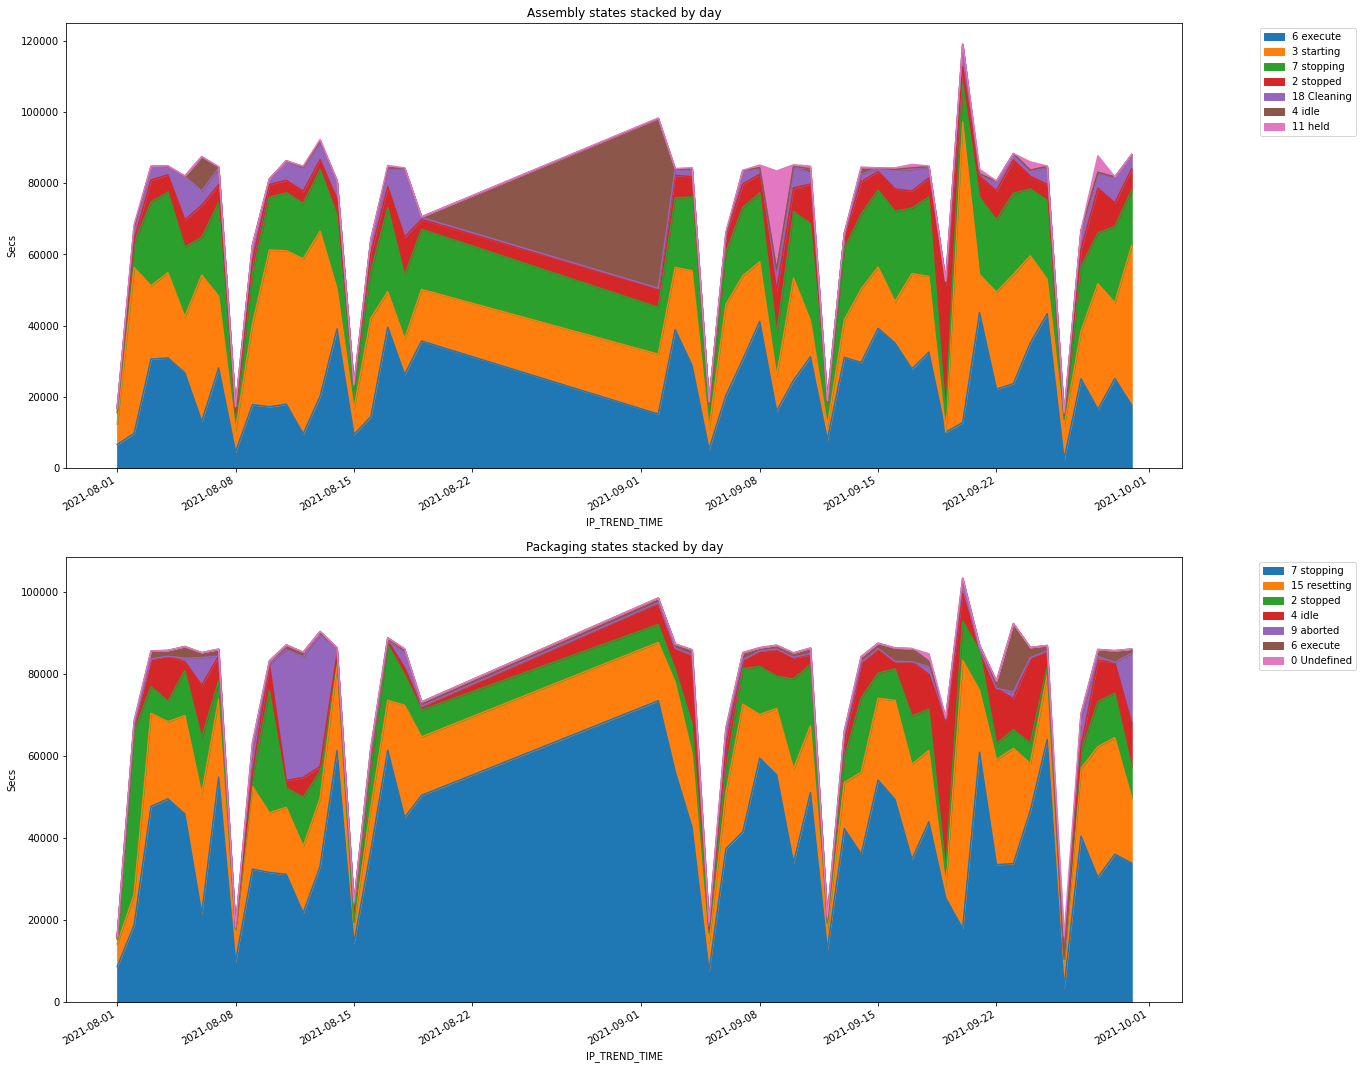

In [16]:
freq='1min'

fig, axs = plt.subplots(len(machines), 1, figsize=(20, 20))

i=0
for x in machines:
    
    high_states = pd.DataFrame(df_omac_unstacked.iloc[:,1:][df_omac_unstacked.Machine == x].sum().nlargest(7))
    cols = high_states.T.columns

    # group[group.Machine == x].hist(label=('{}'.format(x)), ax=axs[i])
    df_omac_unstacked[cols][df_omac_unstacked.Machine == x].plot.area(ax=axs[i])
    axs[i].set_title('{} states stacked by day'.format(x))
    axs[i].set_ylabel('Secs')
    axs[i].legend(loc='upper right', bbox_to_anchor=(1.16, 1.0))
    i+=1


In [17]:
df_run['Time_Diff_Secs'] = df_run.index.sort_values().to_series().diff().dt.seconds

df_run_unstacked = df_run.groupby(['Machine', pd.Grouper(freq='D'), 'IP_TREND_VALUE'])['Time_Diff_Secs'].sum().unstack().reset_index()
df_run_unstacked.set_index('IP_TREND_TIME', inplace=True)
df_run_unstacked

IP_TREND_VALUE,Machine,0,1
IP_TREND_TIME,,,
2021-08-01,Labeler,80125.0,5640.0
2021-08-02,Labeler,74682.0,11428.0
2021-08-03,Labeler,52427.0,33600.0
2021-08-04,Labeler,57844.0,28743.0
2021-08-05,Labeler,58831.0,26933.0
2021-08-06,Labeler,70227.0,16125.0
2021-08-07,Labeler,54275.0,31843.0
2021-08-08,Labeler,79328.0,7415.0
2021-08-09,Labeler,61326.0,24405.0


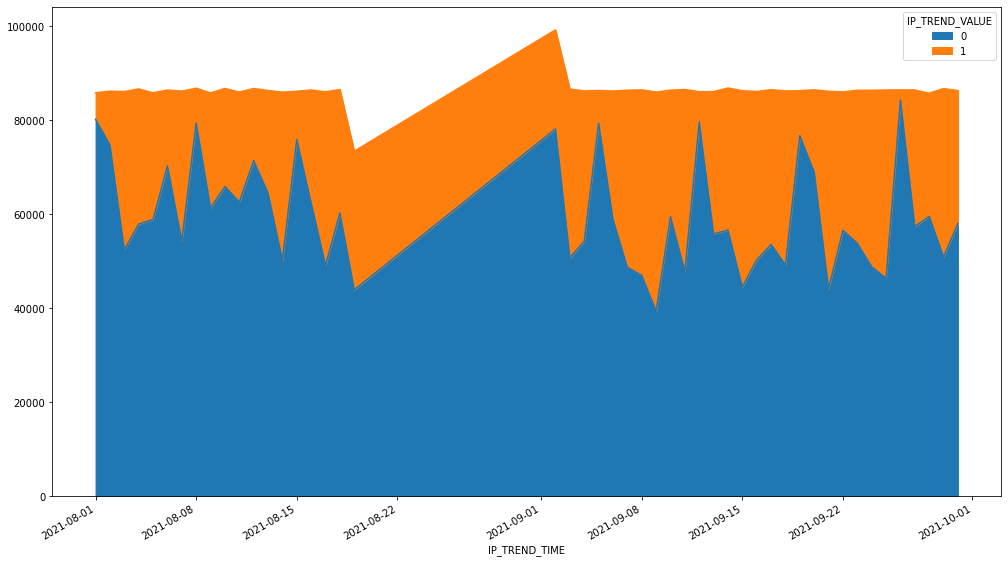

In [18]:
df_run_unstacked.plot.area(figsize=(17,10))
plt.title=('Labeler running status')
plt.set_ylabel=('Elapsed secs')

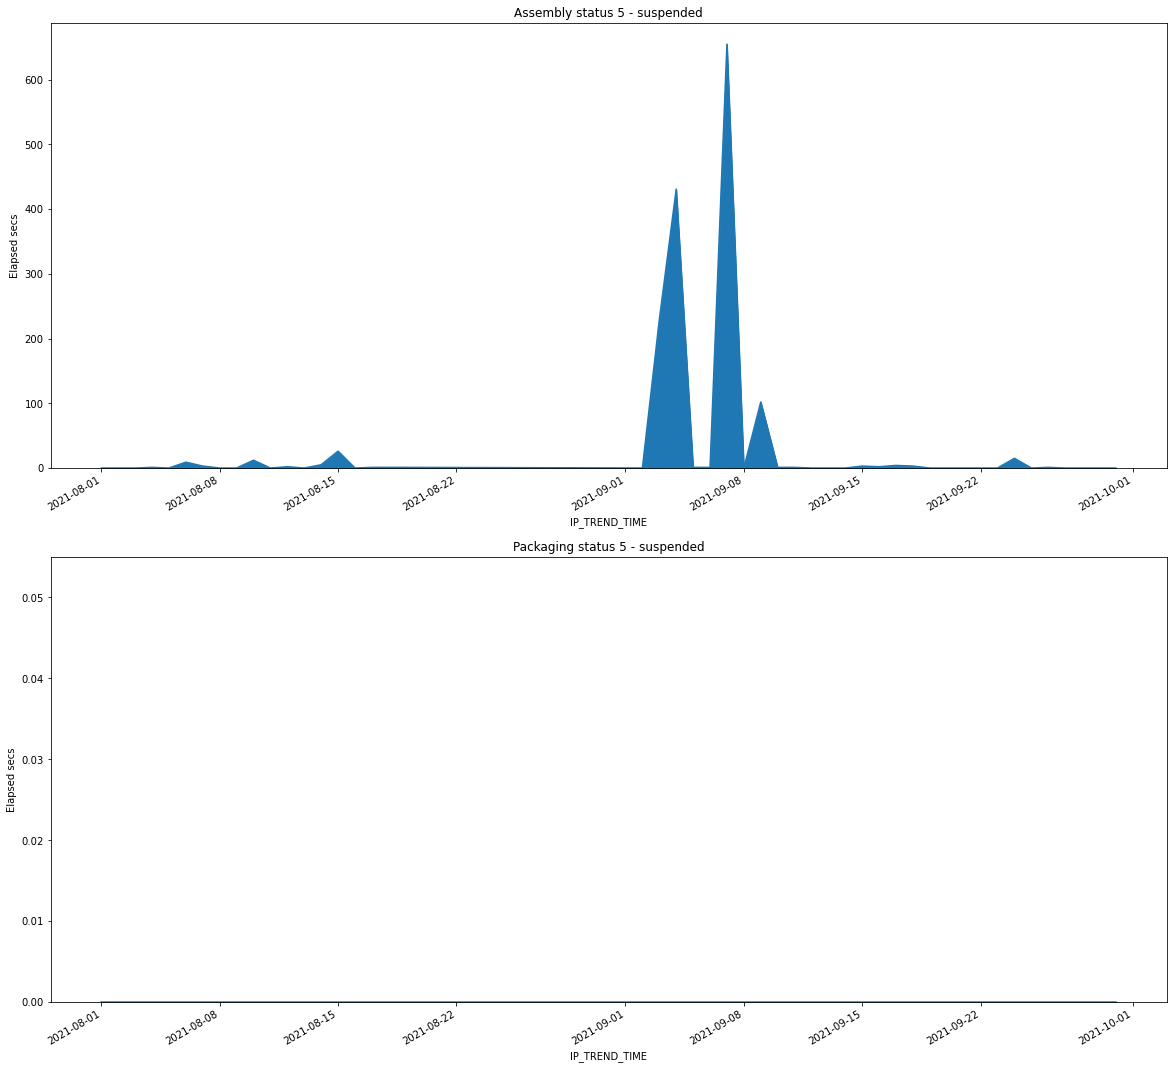

In [19]:
fig, axs = plt.subplots(len(machines), 1, figsize=(20, 20))

i=0
for x in machines:
    # group[group.Machine == x].hist(label=('{}'.format(x)), ax=axs[i])
    df_omac_unstacked[(df_omac_unstacked.Machine == x)]['5 suspended'].plot.area(ax=axs[i])
    axs[i].set_title('{} status 5 - suspended'.format(x))
    axs[i].set_ylabel('Elapsed secs')
    i+=1


In [20]:
df_omac[df_omac.IP_TREND_VALUE == 5].groupby(['Machine','IP_TREND_VALUE']).sum()

,,Time_Diff_Secs
Machine,IP_TREND_VALUE,


In [21]:
df_omac[df_omac.Machine == 'Assembly'].sort_index()

,Name,IP_TREND_VALUE,IP_TREND_QLEVEL,IP_TREND_QSTATUS,Machine,Time_Diff_Secs
IP_TREND_TIME,,,,,,
2021-08-01 00:03:09.500,36630901_OMACSTATE,2 stopped,Good,Good,Assembly,NaN
2021-08-01 00:27:55.900,36630901_OMACSTATE,3 starting,Good,Good,Assembly,1486.0
2021-08-01 00:27:57.000,36630901_OMACSTATE,18 Cleaning,Good,Good,Assembly,1.0
2021-08-01 00:28:04.200,36630901_OMACSTATE,6 execute,Good,Good,Assembly,7.0
2021-08-01 00:28:55.300,36630901_OMACSTATE,7 stopping,Good,Good,Assembly,51.0
...,...,...,...,...,...,...
2021-09-30 23:59:33.500,36630901_OMACSTATE,7 stopping,Good,Good,Assembly,2.0
2021-09-30 23:59:35.600,36630901_OMACSTATE,6 execute,Good,Good,Assembly,2.0
2021-09-30 23:59:36.600,36630901_OMACSTATE,7 stopping,Good,Good,Assembly,1.0


In [22]:
df_run.groupby(['Machine', pd.Grouper(freq='D'), 'IP_TREND_VALUE'])['Time_Diff_Secs'].sum()

Machine  IP_TREND_TIME  IP_TREND_VALUE
Labeler  2021-08-01     0                 80125.0
                        1                  5640.0
         2021-08-02     0                 74682.0
                        1                 11428.0
         2021-08-03     0                 52427.0
                                           ...   
         2021-09-28     1                 26188.0
         2021-09-29     0                 50867.0
                        1                 35794.0
         2021-09-30     0                 58006.0
                        1                 28222.0
Name: Time_Diff_Secs, Length: 96, dtype: float64

In [35]:
df_omac.loc['2021-09-30'].groupby([pd.Grouper(freq='D'),'Machine','IP_TREND_VALUE'])['Time_Diff_Secs'].sum()

IP_TREND_TIME  Machine    IP_TREND_VALUE
2021-09-30     Assembly   19                    2.0
                          1 clearing          973.0
                          11 held              49.0
                          18 Cleaning        3970.0
                          2 stopped          5912.0
                          3 starting        44905.0
                          4 idle               70.0
                          6 execute         17598.0
                          7 stopping        15575.0
               Packaging  1 clearing           40.0
                          15 resetting      15874.0
                          16 completing        52.0
                          2 stopped          7531.0
                          4 idle            10694.0
                          6 execute          1044.0
                          7 stopping        33881.0
                          8 aborting           13.0
                          9 aborted         17030.0
Name: Time_Diff_Secs, d

In [32]:
df_omac.loc['2021-09-30']

,Name,IP_TREND_VALUE,IP_TREND_QLEVEL,IP_TREND_QSTATUS,Machine,Time_Diff_Secs
IP_TREND_TIME,,,,,,
2021-09-30 00:00:00.300,36650901_OMACSTATE,15 resetting,Good,Good,Packaging,1.0
2021-09-30 00:00:03.400,36650901_OMACSTATE,4 idle,Good,Good,Packaging,3.0
2021-09-30 00:00:09.600,36650901_OMACSTATE,16 completing,Good,Good,Packaging,6.0
2021-09-30 00:00:11.700,36650901_OMACSTATE,7 stopping,Good,Good,Packaging,2.0
2021-09-30 00:00:20.900,36650901_OMACSTATE,2 stopped,Good,Good,Packaging,9.0
...,...,...,...,...,...,...
2021-09-30 23:59:33.500,36630901_OMACSTATE,7 stopping,Good,Good,Assembly,2.0
2021-09-30 23:59:35.600,36630901_OMACSTATE,6 execute,Good,Good,Assembly,2.0
2021-09-30 23:59:36.600,36630901_OMACSTATE,7 stopping,Good,Good,Assembly,1.0
